In [3]:
from ete3 import Tree
import networkx as nx 
import pandas as pd 
import numpy as np
from functools import reduce
from tqdm import tqdm_notebook
import pickle as pic 

from collections import OrderedDict, defaultdict

import scipy.stats as scs
import cassiopeia.TreeSolver.compute_meta_purity as cmp
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sys
import os 

import scipy as sp
from scipy.linalg import eig 
import matplotlib

import utilities.compute_transition_probs as ctp
import utilities.fitch_parsimony as fp
import utilities.sankoff_parsimony as sankoff_parsimony

from contextlib import suppress

from cassiopeia.TreeSolver.Node import Node
import itertools

from tqdm import tqdm

import cassiopeia.TreeSolver.post_process_tree as ppt

from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA

import umap
import numba

In [2]:

def reconcile_fitch(T):
    
    source = [n for n in T if T.in_degree(n) == 0][0]
    for e in nx.dfs_edges(T):
        
        p, c = e[0], e[1]
        ns = np.intersect1d(T.nodes[p]['label'], T.nodes[c]['label']).tolist()
        
        if len(ns) > 0 and len(ns) == len(T.nodes[p]['label']):
            T.nodes[c]['label'] = ns 
        else:
            T.nodes[c]['label'] = list(T.nodes[c]['label'])
    return T

def count_opt_solutions(T, possible_assignments, node_to_i, label_to_j):
    
    def fill_DP(v, s):

        if T.out_degree(v) == 0:
            return 1
        
        children = list(T.successors(v))
        A = np.zeros((len(children)))
        
        for i, u in zip(range(len(children)), children):
            if s not in T.nodes[u]['label']:
                A[i] = 0
                for sp in T.nodes[u]['label']:
                    if L[node_to_i[u], label_to_j[sp]] == 0:
                        L[node_to_i[u], label_to_j[sp]] = fill_DP(u, sp)
                    A[i] += L[node_to_i[u], label_to_j[sp]]
            else:
                if L[node_to_i[u], label_to_j[s]] == 0:
                    L[node_to_i[u], label_to_j[s]] = fill_DP(u, s)
                A[i] = L[node_to_i[u], label_to_j[s]]
                
        return np.prod([A[u] for u in range(len(A))])
    
    L = np.full((len(T.nodes), len(possible_assignments)), 0)
    
    root = [n for n in T if T.in_degree(n) == 0][0]
    
    for s in T.nodes[root]['label']:
        L[node_to_i[root], label_to_j[s]] = fill_DP(root, s)
    return L

def count_num_transitions(T, L, possible_labels, node_to_i, label_to_j, unique=True):
    
    def fill_transition_DP(v, s, s1, s2, obs_transitions, unique):
        
        if T.out_degree(v) == 0:
            return 0
        
        children = list(T.successors(v))
        A = np.zeros((len(children)))
        LS = [[]] * len(children)
        
        for i, u in zip(range(len(children)), children):
            LS_u = None
            if s in T.nodes[u]['label']:
                LS[i] = [s]
            else:
                LS[i] = T.nodes[u]['label']
            
            A[i] = 0
            for sp in LS[i]:
                
                if not unique:
                    A[i] += C[node_to_i[u], label_to_j[sp], label_to_j[s1], label_to_j[s2]]
                else:
                    A[i] += min(1, C[node_to_i[u], label_to_j[sp], label_to_j[s1], label_to_j[s2]])
                    
            if (s1 == s and s2 in LS[i] and s1 != s2):
                
                if unique:
                    A[i] += min(1, L[node_to_i[u], label_to_j[s2]])
                else:
                    A[i] += L[node_to_i[u], label_to_j[s2]]
                 
        parts = []
        for i, u in zip(range(len(children)), children):
            prod = 1
            
            for k, up in zip(range(len(children)), children):
                fact = 0
                if up == u:
                    continue
                for sp in LS[k]:
                    fact += L[node_to_i[up], label_to_j[sp]]
                
                prod *= fact 
            
            if not unique:
                part = A[i] * prod
            else:
                if (s1, s2) not in obs_transitions[(v, u)]:
                    part = A[i]
                    if part > 0:
                        obs_transitions[(v, u)].append((s1, s2))
                else:
                    part = 0
                    
            parts.append(part)
        
        return np.sum(parts)
    
    C = np.zeros((len(T.nodes), L.shape[1], L.shape[1], L.shape[1]))
    root = [n for n in T if T.in_degree(n) == 0][0]
    
    obs_transitions = defaultdict(list)
    
    for n in nx.dfs_postorder_nodes(T, source=root):
        for s in T.nodes[n]['label']:
            for s_pair in itertools.product(possible_labels, repeat=2):
                s1, s2 = s_pair[0], s_pair[1]
                C[node_to_i[n], label_to_j[s], label_to_j[s1], label_to_j[s2]] = fill_transition_DP(n, s, s1, s2, obs_transitions, unique)
                
    return C

def compute_transitions(t, meta, count_unique = True):

    
    root = [n for n in t if t.in_degree(n) == 0][0]
    t = ctp.assign_labels(t, meta)
    possible_labels = meta.unique()

    t = cmp.set_depth(t, root)
    t = fp.fitch_bottom_up(t, root)

    bfs_postorder = [root]
    for e0, e1 in nx.bfs_edges(t, root):
        bfs_postorder.append(e1)

    node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
    label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

    t = reconcile_fitch(t)

    L = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)
    
    obs_transitions = defaultdict(list)
    
    C = count_num_transitions(t, L, possible_labels, node_to_i, label_to_j, unique = count_unique)

    count_mat = pd.DataFrame(np.zeros((L.shape[1], L.shape[1])))
    count_mat.columns = possible_labels
    count_mat.index = possible_labels 

    # count_mat: transitions are rows -> columns
    for s1 in possible_labels:
        for s2 in possible_labels:
            if s1 != s2:
                count_mat.loc[s1, s2] = np.sum(C[node_to_i[root], :, label_to_j[s1], label_to_j[s2]])

    return count_mat


In [ ]:
t = nx.DiGraph()
t.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
t.add_edges_from([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (5, 9), (5, 10), (6, 11), (6, 12)])

rndict = {}
for n in t.node:
    nn = Node(n, [])
    rndict[n] = nn  

t = nx.relabel_nodes(t, rndict)

label_dict = {7: 'A', 8: 'T', 4: 'C', 9: 'A', 10: 'G', 11: 'T', 12: 'C'}

meta = pd.DataFrame.from_dict(label_dict, orient='index')

root = [n for n in t if t.in_degree(n) == 0][0]
t = ctp.assign_labels(t, meta.iloc[:,0])
possible_labels = meta.iloc[:,0].unique()

t = cmp.set_depth(t, root)
t = fp.fitch_bottom_up(t, root)

bfs_postorder = [root]
for e0, e1 in nx.bfs_edges(t, root):
    bfs_postorder.append(e1)

node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

t = reconcile_fitch(t)

L = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)
    
mat = compute_transitions(t, meta.iloc[:,0], count_unique=True)

print(mat.loc[['C', 'A', 'T', 'G'], ['C', 'A', 'T', 'G']])

In [ ]:
ctp.compute_transitions(t, meta.loc[:,0], count_unique = True).loc[['C', 'A', 'T', 'G'], ['C', 'A', 'T', 'G']]

In [ ]:
def test1():
    
    t = nx.DiGraph()

    t.add_nodes_from([0, 1, 2,3 ,4 , 5, 6, 7, 8,9, 10, 11, 12])
    t.add_edges_from([(0, 1),(0,2), (1,3), (1,4), (2,5), (2,6), (3,7), (3,8), (5,9), (5,10), (6,11), (6,12)])
    rndict = {}
    for n in t.node:
        nn = Node(n, [])
        rndict[n] = nn
    t = nx.relabel_nodes(t, rndict)

    label_dict = {4: 'C', 7: 'A', 8: 'T', 9: 'A', 10: 'G', 11: 'T', 12: 'C'}

    meta = pd.DataFrame.from_dict(label_dict, orient='index')
    
    root = [n for n in t if t.in_degree(n) == 0][0]
    t = ctp.assign_labels(t, meta.iloc[:,0])
    possible_labels = meta.iloc[:,0].unique()

    t = cmp.set_depth(t, root)
    t = fp.fitch_bottom_up(t, root)

    bfs_postorder = [root]
    for e0, e1 in nx.bfs_edges(t, root):
        bfs_postorder.append(e1)

    node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
    label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

    t = reconcile_fitch(t)
    
    L = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)
    
    mat = compute_transitions(t, meta.iloc[:,0])
    
    print(mat)
    
def test2():
    
    t = nx.balanced_tree(2,3, create_using=nx.DiGraph())
    
    rndict={}
    for n in t.node:
        nn = Node(n, [])
        rndict[n] = nn  

    t = nx.relabel_nodes(t, rndict)

    label_dict = {7: 'H', 8: 'G', 9: 'G', 10: 'M', 11: 'L', 12: 'M', 13: 'L', 14: 'M'}

    meta = pd.DataFrame.from_dict(label_dict, orient='index')

    root = [n for n in t if t.in_degree(n) == 0][0]
    t = ctp.assign_labels(t, meta.iloc[:,0])
    possible_labels = meta.iloc[:,0].unique()

    t = cmp.set_depth(t, root)
    t = fp.fitch_bottom_up(t, root)

    bfs_postorder = [root]
    for e0, e1 in nx.bfs_edges(t, root):
        bfs_postorder.append(e1)

    node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
    label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

    t = reconcile_fitch(t)

    L = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)
    
    mat = compute_transitions(t, meta.iloc[:,0])
        
    print(mat)
    
    

In [ ]:
test2()

In [ ]:
t = nx.balanced_tree(2,3, create_using=nx.DiGraph())
    
rndict={}
for n in t.node:
    nn = Node(n, [])
    rndict[n] = nn  

t = nx.relabel_nodes(t, rndict)

label_dict = {7: 'H', 8: 'G', 9: 'G', 10: 'M', 11: 'L', 12: 'M', 13: 'L', 14: 'M'}

meta = pd.DataFrame.from_dict(label_dict, orient='index')

root = [n for n in t if t.in_degree(n) == 0][0]
t = ctp.assign_labels(t, meta.iloc[:,0])
possible_labels = meta.iloc[:,0].unique()

t = cmp.set_depth(t, root)
t = fp.fitch_bottom_up(t, root)

bfs_postorder = [root]
for e0, e1 in nx.bfs_edges(t, root):
    bfs_postorder.append(e1)
    
node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

t = reconcile_fitch(t)

    
L = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)

compute_transitions(t, meta.iloc[:,0])

In [ ]:
t = ctp.assign_labels(t, meta.iloc[:,0])
possible_labels = meta.iloc[:,0].unique()

C = sankoff_parsimony.sankoff(t, possible_labels=possible_labels)
pars = np.amin(C[0,:])

root = [n for n in t if t.in_degree(n) == 0][0]
    
bfs_postorder = [root]
for e0, e1 in nx.bfs_edges(t, root):
    bfs_postorder.append(e1)

node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

opt_solutions_root = np.where(C[node_to_i[root], :] == pars)[0] 

tmat = np.zeros((C.shape[1], C.shape[1]))
for o in opt_solutions_root:
    sol, tm = count_opt_solutions_DP(t, C, root, o, node_to_i)
    tmat += tm 

tmat


In [ ]:
tmat, semat = ctp.compute_transition_matrix(t, meta.iloc[:,0], iterations = 100, plot=False)
print(tmat)

In [ ]:
t = ctp.assign_labels(t, meta.iloc[:,0])
possible_labels = meta.iloc[:,0].unique()

C = sankoff_parsimony.sankoff(t, possible_labels=possible_labels)
# print(C)
pars = np.amin(C[0,:])

root = [n for n in t if t.in_degree(n) == 0][0]
    
bfs_postorder = [root]
for e0, e1 in nx.bfs_edges(t, root):
    bfs_postorder.append(e1)

node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

num_sol, t_mat = count_opt_solutions(t, C, root, node_to_i, t_mat = np.zeros((C.shape[1], C.shape[1])))
num_sol, t_mat
# print(num_sol)
# print(t_mat)
# print(t_mat / (pars * num_sol))

## Read in lineage groups

In [6]:
lg_meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

home_dir = '/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/'


lg_to_tree = {}
lg_to_cm = {}
for tree_dir in tqdm(os.listdir(home_dir)):
    tree_dir = home_dir + tree_dir + "/"

    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    fps = [fp for fp in os.listdir(tree_dir) if "alleleThresh.pkl" in fp and "tree" in fp and 'nj' not in fp]
    cms = [fp for fp in os.listdir(tree_dir) if 'character_matrix.alleleThresh.txt' in fp]
    
    if lg == '5':
        print(fps[0])
    if len(fps) > 0:
        
        try:
            tree = pic.load(open((tree_dir + fps[0]), 'rb'))
            lg_to_tree[int(lg)] = tree
            
            lg_to_cm[int(lg)] = pd.read_csv(tree_dir + cms[0], sep='\t', index_col = 0)
        except:
            continue

 35%|███▍      | 39/113 [00:30<00:31,  2.33it/s]

lg5_tree_hybrid_priorsalleleThresh.pkl


100%|██████████| 113/113 [01:44<00:00,  1.44it/s]


In [6]:
lg = lg_to_tree[5]
# lg = pic.load(open('/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg5/lg5_tree_hybrid_priorsalleleThresh.pkl', 'rb'))
cm = lg_to_cm[5]

plg = lg.post_process(cm).network

# root = [n for n in plg if plg.in_degree(n) == 0]
# t = ctp.assign_labels(plg, lg_meta['sampleID'])
count_arr = ctp.compute_transitions(plg, lg_meta['sampleID'], count_unique=False)
np.fill_diagonal(count_arr.values,0)

count_arr = count_arr.apply(lambda x: x / x.sum(), axis=1)
count_arr

,RW,RE,M2,M1,Liv,LL
RW,0.000000,0.063912,0.135009,0.785209,0.012995,0.002875
RE,0.102678,0.000000,0.205739,0.655258,0.034270,0.002055
M2,0.074538,0.084464,0.000000,0.801275,0.039018,0.000705
M1,0.269731,0.134300,0.514265,0.000000,0.065187,0.016518
Liv,0.057563,0.083171,0.195113,0.643079,0.000000,0.021073
LL,0.081002,0.067879,0.242422,0.580910,0.027787,0.000000


## Form Transition Matrices

In [7]:
count_arrs = []
lgs = []

for _lg in tqdm(lg_to_tree.keys()):
    
    try:
        lg = lg_to_tree[_lg]
        cm = lg_to_cm[_lg]
        
        plg = lg.post_process(cm).network
        
        count_arr = ctp.compute_transitions(plg, lg_meta['sampleID'], count_unique = False)
        np.fill_diagonal(count_arr.values,0)
        count_arr = count_arr.apply(lambda x: x / x.sum(), axis=1)

        # count_arr = count_arr / max(1, np.sum(count_arr.values))
        
        # np.fill_diagonal(count_arr.values, np.nan)
        # z-normalize
        # count_arr = count_arr.apply(lambda x: (x - x.mean()) / (np.sqrt(x.var())), axis=0)
        
        #alt_counts = []
        num_alt = 0
#         for alt in tqdm(lg_to_tree[_lg].alternative_solutions, desc="Evaluting alternative solutions"):
            
#             try:
#                 alt = ppt.post_process_tree(alt, cm, 'hybrid')                
#                 carr = ctp.compute_transitions(alt, lg_meta['sampleID'], count_unique=True)

#                 np.fill_diagonal(carr.values,0)
#                 carr = carr / np.sum(carr.values)

#                 count_arr += carr
#                 num_alt += 1
#             except:
#                 continue
        
        count_arr /= (num_alt + 1)
            
        count_arrs.append(count_arr)
        lgs.append(_lg)
                    
#         cmap = matplotlib.cm.RdBu
#         cmap.set_bad("white", 1.)
#         h = plt.figure(figsize=(10, 10))
#         sns.heatmap(count_arr.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]], center=0, mask = np.fill_diagonal(np.zeros(count_arr.shape), 1), cmap="RdBu_r")
#         plt.ylabel("Origin Tissue")
#         plt.xlabel("Destination Tissue")
#         plt.title("Unnormalized Transition Probabilities, LG" + str(_lg))
#         plt.savefig("figs/5kTransition/lg" + str(_lg) + "_transitionmat_unnorm.png")
#         plt.close()

        # read in and normalize background
#         bg = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/transition_backgrounds/lg" + str(_lg) + "_background_mat.txt", sep='\t', index_col = 0)
#         labels = bg.columns
#         np.fill_diagonal(bg.values,0)
#         bg_n = bg / np.sum(bg.values)

#         np.fill_diagonal(bg_n.values, np.nan)

#         # z-normalize
#         bg_n = bg_n.apply(lambda x: (x - x.mean()) / (np.sqrt(x.var())), axis=0)

#         bg_n = pd.DataFrame(bg_n, index=labels, columns=labels)

#         # normalized 
#         res = count_arr.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]] - bg_n.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]]
#         cmap = matplotlib.cm.RdBu
#         cmap.set_bad("white", 1.)
#         h = plt.figure(figsize=(10, 10))
#         sns.heatmap(res, mask = np.fill_diagonal(np.zeros(res.shape), 1), cmap="RdBu_r", center=0)
#         plt.ylabel("Origin Tissue")
#         plt.xlabel("Destination Tissue")
#         plt.title("Normalized Transition Probabilities, LG" + str(_lg))
#         plt.savefig("figs/5kTransition/lg" + str(_lg) + "_transitionmat_norm.png")
#         plt.close()
    except:
        print(_lg)
    

100%|██████████| 98/98 [03:19<00:00,  1.92it/s]


In [11]:
for lg in lg_to_countarr:
    print(lg_to_countarr[lg], lg)
    break

NameError: name 'lg_to_countarr' is not defined

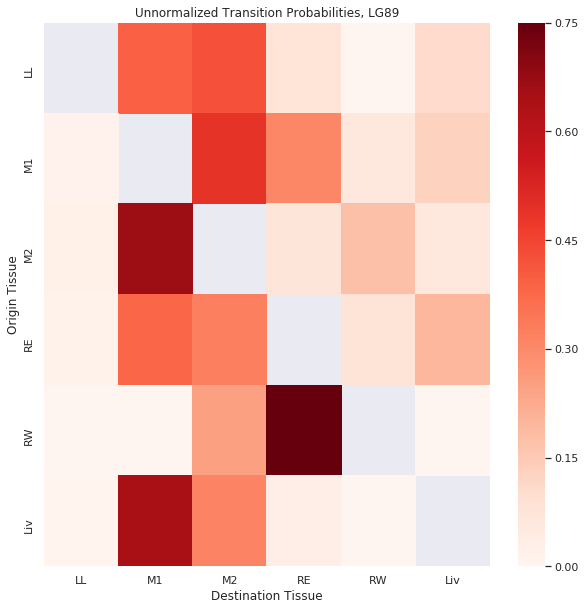

In [9]:
lg_to_countarr = dict(zip(lgs, count_arrs))
count_arr = lg_to_countarr[19]
h = plt.figure(figsize=(10, 10))
np.fill_diagonal(count_arr.values,np.nan)
sns.heatmap(count_arr.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]], mask = np.fill_diagonal(np.zeros(count_arr.shape), 1), cmap="Reds")
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
plt.title("Unnormalized Transition Probabilities, LG" + str(_lg))
plt.show()

### Look at some examples

               RW            RE            M2            M1           Liv  \
RW            NaN  3.694838e-85  2.873763e-85  7.800213e-85  1.642150e-85   
RE   2.463225e-85           NaN  3.694838e-85  1.067398e-84  1.642150e-85   
M2   2.463225e-85  4.105375e-85           NaN  7.800213e-85  1.642150e-85   
M1   2.873763e-85  4.105375e-85  4.926450e-85           NaN  2.463225e-85   
Liv  1.642150e-85  3.284300e-85  2.463225e-85  1.067398e-84           NaN   
LL   2.052688e-85  4.105375e-85  2.873763e-85  1.000000e+00  2.052688e-85   

               LL  
RW   2.873763e-85  
RE   2.463225e-85  
M2   2.463225e-85  
M1   3.284300e-85  
Liv  2.463225e-85  
LL            NaN  


Text(0.5, 1.0, 'Unnormalized Transition Probabilities, LG72')

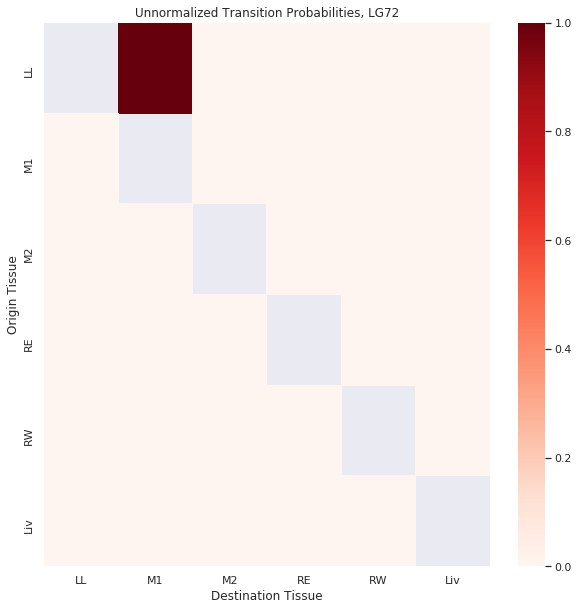

In [199]:
lg1 = lg_to_tree[19]
pg = lg1.post_process(lg_to_cm[2])
count_arr = ctp.compute_transitions(pg.network, lg_meta['sampleID'], count_unique = True)

np.fill_diagonal(count_arr.values,0)

count_arr = count_arr / np.sum(count_arr.values)

np.fill_diagonal(count_arr.values, np.nan)
print(count_arr)


# z-normalize
# count_arr = count_arr.apply(lambda x: (x - x.mean()) / (np.sqrt(x.var())), axis=0)

cmap = matplotlib.cm.RdBu
cmap.set_bad("white", 1.)
h = plt.figure(figsize=(10, 10))
sns.heatmap(count_arr.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]], mask = np.fill_diagonal(np.zeros(count_arr.shape), 1), cmap="Reds")
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
plt.title("Unnormalized Transition Probabilities, LG72")
# plt.savefig('figs/lg19_transitionmat.pdf')

# lg1 = ctp.assign_labels(lg1,lg_meta['sampleID'])
# possible_labels = lg_meta['sampleID'].unique()

# C = sankoff_parsimony.sankoff(lg1, possible_labels=possible_labels)
# # print(C)
# pars = np.amin(C[0,:])
# print(pars)

# root = [n for n in lg1 if lg1.in_degree(n) == 0][0]
    
# bfs_postorder = [root]
# for e0, e1 in nx.bfs_edges(lg1, root):
#     bfs_postorder.append(e1)

# node_to_i = dict(zip(bfs_postorder, range(len(lg1.nodes))))
# label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

# num_sol, t_mat = count_opt_solutions(lg1, C, root, node_to_i, label_to_j, t_mat = np.zeros((C.shape[1], C.shape[1])))
# print(t_mat / (pars * num_sol))

In [ ]:
bg = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/transition_backgrounds/lg80_background_mat.txt", sep='\t', index_col = 0)
labels = bg.columns
np.fill_diagonal(bg.values,0)
bg_n = bg / np.sum(bg.values)

np.fill_diagonal(bg_n.values, np.nan)

# z-normalize
bg_n = bg_n.apply(lambda x: (x - x.mean()) / (np.sqrt(x.var())), axis=0)

bg_n = pd.DataFrame(bg_n, index=labels, columns=labels)
print(bg)
cmap = matplotlib.cm.RdBu

cmap.set_bad("white", 1.)
h = plt.figure(figsize=(10, 10))
sns.heatmap(bg_n.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]], mask = np.fill_diagonal(np.zeros(bg.shape), 1), cmap="RdBu_r")
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
plt.title("Random Background Transition Probabilities, LG72")
# plt.savefig('figs/lg19_randbg.pdf')

In [ ]:
res = count_arr.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]] - bg_n.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]]

print(np.median(res.fillna(value=0).values.flatten()))

cmap = matplotlib.cm.RdBu
cmap.set_bad("white", 1.)
h = plt.figure(figsize=(10, 10))
sns.heatmap(res, mask = np.fill_diagonal(np.zeros(res.shape), 1), cmap="RdBu_r", center=0)
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
plt.title("Normalized Transition Probabilities, LG80")
# plt.savefig('figs/lg19_transitionmat_norm.pdf')


## Summarize transition matrices

In [8]:
def compute_dissimilarity(mat, method='frobenius'):
    
    dists = np.zeros((mat.shape[0], mat.shape[0]))
    if method == 'frobenius':
        
        for i in range(mat.shape[0]):
            for j in range(i+1, mat.shape[0]):
                dif = mat[i,:] - mat[j,:]
                dif = np.square(dif)
                dif = np.sqrt(np.sum(dif))

                dists[i,j] = dif
                
    if method == 'cosine':
        
        for i in range(mat.shape[0]):
            for j in range(i+1, mat.shape[0]):
                
                dists[i,j] = sp.spatial.distance.cosine(mat[i,:], mat[j,:])
                
    if method == 'euclidean':
        
        for i in range(mat.shape[0]):
            for j in range(i + 1, mat.shape[0]):
                
                dists[i, j] = sp.spatial.distance.euclidean(mat[i,:], mat[j,:])
                
    return dists

@numba.njit()
def kl_divergence(a, b):
    
    kl_a = np.sum([a[i]*np.log(a[i]/b[i])] for i in range(len(a)))
    kl_b = np.sum([b[i] * np.log(b[i]/a[i])] for i in range(len(b)))
    
    return kl_a + kl_b

In [10]:
# transition_matrices = dict(zip(lgs, count_arrs))
transition_matrices = lg_to_countarr

#transition_matrices = pic.load(open('transition_matrices.5k.pkl', 'rb'))
transition_vectors = [np.nan_to_num(_item[1].values.flatten()) for _item in transition_matrices.items()]

lgs = [_item[0] for _item in transition_matrices.items()]

tmat = np.array(transition_vectors)
print(tmat.shape)

norms = compute_dissimilarity(tmat, method='frobenius')
norms = norms.T + norms
norms = np.nan_to_num(norms, nan = 0)

# embedding = MDS(n_components=2, dissimilarity='precomputed')
# tmat_transformed = embedding.fit_transform(norms)

#tmat_transformed = TSNE(n_components=2, perplexity = 30).fit_transform(tmat)

#fit = umap.UMAP(n_neighbors = 10, metric= 'euclidean')
fit = umap.UMAP(n_neighbors=10, metric=kl_divergence)
tmat_transformed = fit.fit_transform(tmat)

# embedding = PCA(n_components=2)
# tmat_transformed = embedding.fit_transform(tmat)

NameError: name 'lg_to_countarr' is not defined

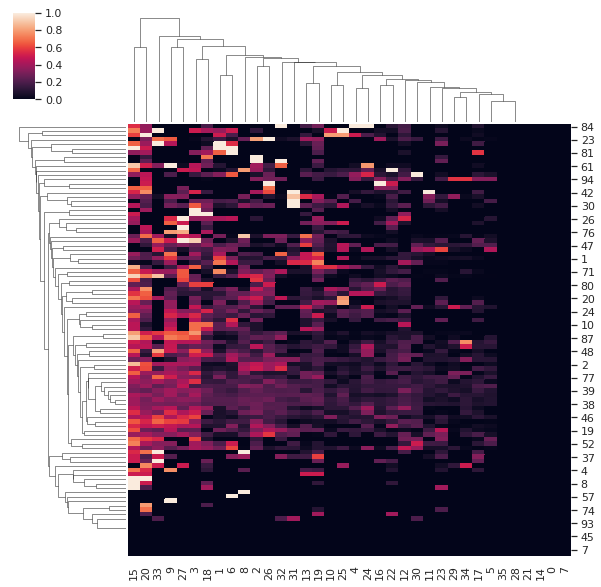

In [80]:
sns.clustermap(tmat)

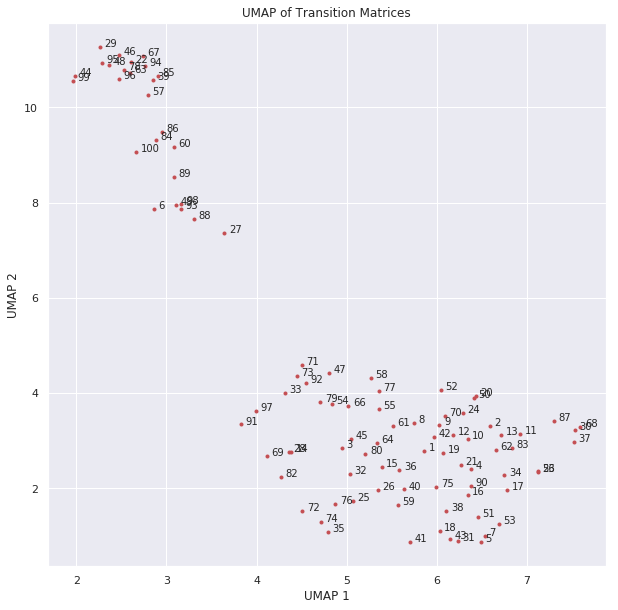

In [75]:
x, y = tmat_transformed[:,0], tmat_transformed[:, 1]
sizes = dict(zip(lgs, x))
ss = dict(zip(lgs, y))
labs = lgs

h = plt.figure(figsize = (10, 10))
plt.plot(x, y, 'r.')
# plt.xscale('log')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP of Transition Matrices")

for i in labs:
    plt.annotate(i, (sizes[i]+0.05, ss[i]+0.01))
                     
# plt.savefig('figs/5k/umap_transitionmatrcies.‹mulstisoln.pdf')

# sns.scatterplot(tmat_transformed[:,0], tmat_transformed[:,1])


Text(0.5, 57.5, 'Destination Tissue')

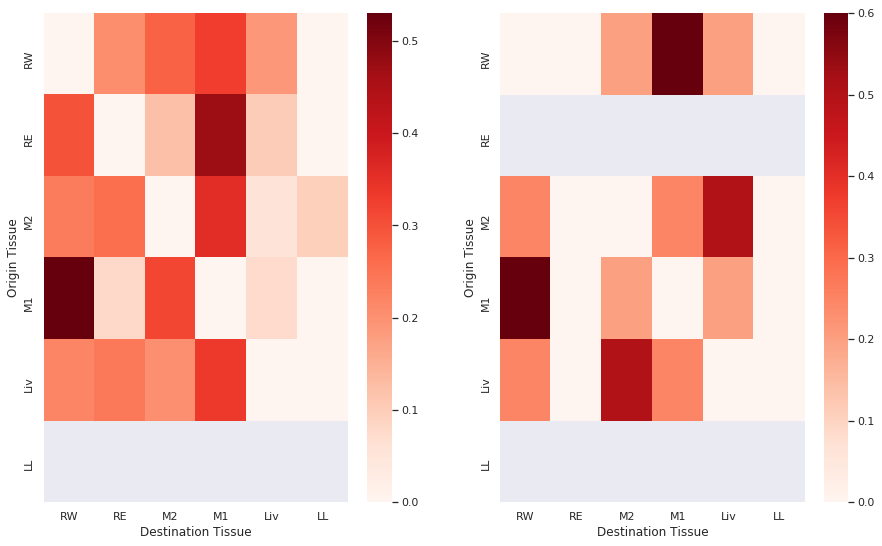

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))

res = transition_matrices[54]
#h = plt.figure(figsize=(10, 10))
sns.heatmap(res, mask = np.fill_diagonal(np.zeros(res.shape), 1), cmap="Reds", ax=axes[0])
axes[0].set_ylabel("Origin Tissue")
axes[0].set_xlabel("Destination Tissue")
# axes[0].set_title("Average Transition Probabilities, L36")

res = transition_matrices[79]
# h = plt.figure(figsize=(10, 10))
sns.heatmap(res, mask = np.fill_diagonal(np.zeros(res.shape), 1), cmap="Reds", ax=axes[1])
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
# plt.title("Average Transition Probabilities, LG82")
